In [1]:
# do this if you use a custom virtual environment to specify the directory to look for installed packages
import sys
import os
## goes back to the project directory
os.chdir("..")
# switch to the name of your virtual environment
kernel_name = ".venv_mp"
sys.path.append("\\".join([os.getcwd(), kernel_name, "Lib\\site-packages"]))

In [2]:
import pandas as pd

In [3]:
methods = ["MMD", "MMD OCSVM Verify", "OCSVM"]
model_types = {"kernel=\'linear\'" : "linear", "SVR(":"non-linear", "LinearRegression" : "LReg"}
kernel_colors = {"linear" : "r", "non-linear" : "b", "LReg" : "o", "combined" : "g"}
colors = ["bo", "go", "ro", "co", "mo", "yo", "ko"]
direction_markers = [">", "<"]
marker_meaning = {">" : "forward", "<" : "backwards"}
normalized = {True : "-std", False: ""}
alpha_norm = {True : 1/3, False: 2/3}

In [4]:
def sort_similar_pairs(df):
    n_pairs =  int(df.shape[0]/2)
    
    for pair_index in range(n_pairs):
        pair = df.iloc[pair_index*2].copy()
        backwards_pair =  df.loc[(df.test_node == pair.model_node) & 
                                (df.model_node == pair.test_node)]

        if pair_index*2+1 != backwards_pair.index:
            misplaced_pair = df.loc[pair_index*2+1]
            df.iloc[backwards_pair.index] = misplaced_pair
            df.iloc[pair_index*2+1] = backwards_pair

        if pair.model_node > pair.test_node:
            df.iloc[pair_index*2] = backwards_pair
            df.iloc[pair_index*2+1] = pair

    similar_pairs = [pair for pair in df.values]
    
    return similar_pairs

def get_pair_df(pair, df):
    forward_match = ((df.model_node==pair[0])&(df.test_node==pair[1]))
    backward_match = ((df.model_node==pair[1])&(df.test_node==pair[0]))
    regex_model_types = "|".join(["kernel=\'linear\'", "SVR"])
    model_type_match = (df.model.str.contains(regex_model_types, regex=True))
    pair_df = df.loc[(forward_match|backward_match) & (model_type_match)]
    return pair_df

def get_linear_non_linear_df(df):
    df_linear = df.loc[df.model.str.contains("kernel=\'linear\'")]
    df_non_linear = pd.concat([df,df_linear]).drop_duplicates(keep=False)
    return df_linear, df_non_linear

In [25]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np

def plot_r2_discrpenacy(data, omit_bad_pairs=False):
    stats = {}
        
    for experiment in range(1,4):
        experiment_stats = pd.DataFrame(columns = data.discrepancy.describe().index)
        df = data.loc[(data.experiment==experiment)]
        unique_pairs_df = pd.DataFrame.from_records(np.unique(df[["model_node", "test_node"]].to_records(index=False)))     
        similar_pairs = sort_similar_pairs(unique_pairs_df)
        pair_dfs = {str((pair[0], pair[1])): get_pair_df(pair, df) for pair in similar_pairs[::2]}
        
        if omit_bad_pairs:
            pair_dfs = {pair: pair_df for pair, pair_df in pair_dfs.items() if pair_df.discrepancy.min()<1}
        
        n_pairs = len(pair_dfs)

        fig, axs = plt.subplots(nrows = n_pairs, ncols = 3, sharey="col", figsize= (12, n_pairs * 3))
        fig.suptitle("Experiment "+ str(experiment), fontsize =15)
        fig.tight_layout(pad=3.0)
        
        xlabel = "Discrepancy"
        ylabel = "Coefficient of Determination"
        
        if n_pairs > 1:
            pair_index=0
        
        
        for pair, pair_df in pair_dfs.items():     
            for row in pair_df.loc[pair_df.method == pd.unique(pair_df.method)[0]].itertuples(index=False):
                model_type = [model_types[m] for m in model_types if m in row.model][0]
                color = kernel_colors[model_type]
                x, y = row.discrepancy, row.score

                if row.model_node < row.test_node:
                    direction = 0
                else:
                    direction = 1 
                args = [color, alpha_norm[row.std], direction_markers[direction]]

                if n_pairs == 1:
                    axs[1].plot(x, y, args[0], alpha = args[1], marker = args[2])
                else:
                    axs[pair_index,1].plot(x, y, args[0], alpha = args[1], marker = args[2])

            forward = pair_df.loc[pair_df.model_node < pair_df.test_node]
            backward = pair_df.loc[pair_df.model_node > pair_df.test_node]
            backward_pair = str((backward.model_node.values[0], backward.test_node.values[0]))
            
            forward_linear, forward_non_linear = get_linear_non_linear_df(forward)
            backward_linear, backward_non_linear = get_linear_non_linear_df(backward)
            
            experiment_stats.loc[pair] = forward.discrepancy.describe().values.T
            experiment_stats.loc[backward_pair] = backward.discrepancy.describe().values.T
            
            main_title = f"{pair}"
            
            pair_methods_thresholds = ", ".join([f"{method}({forward.loc[forward.method == method].threshold.values[0]})" 
                                                 for method in pd.unique(pair_df.method)])
            left_title = f"{pair}-({pair_methods_thresholds})"
            
            backward_pair_methods_thresholds = ", ".join([f"{method}({backward.loc[backward.method == method].threshold.values[0]})" 
                                                          for method in pd.unique(pair_df.method)])
            right_title = f"{backward_pair}-({backward_pair_methods_thresholds})"
            
            if n_pairs == 1:
                axs[0].set_title(left_title, fontsize=10)
                axs[1].set_title(main_title, fontsize=10)
                axs[2].set_title(right_title, fontsize=10)
                
                [axs[i].set_xlabel(xlabel) for i in range(3)]
                axs[1].set_ylabel(ylabel)
                if omit_bad_pairs:
                    axs[1].set_xlim([0,1.0])
                    
                axs[0].hist(forward.discrepancy, bins = 4, color="g", alpha=2/3)
                axs[2].hist(backward.discrepancy, bins = 4, color="g", alpha=2/3)
                
                axs[0].hist(forward_linear.discrepancy, bins = 4, color="r", alpha=2/3)
                axs[0].hist(forward_non_linear.discrepancy, bins = 4, color="b", alpha=2/3)
                
                axs[2].hist(backward_linear.discrepancy, bins = 4, color="r", alpha=2/3)
                axs[2].hist(backward_non_linear.discrepancy, bins = 4, color="b", alpha=2/3)
            else:
                axs[pair_index,0].set_title(left_title, fontsize=10)
                axs[pair_index,1].set_title(main_title, fontsize=10)
                axs[pair_index,2].set_title(right_title, fontsize=10)
                
                [axs[pair_index,i].set_xlabel(xlabel) for i in range(3)]
                axs[pair_index,1].set_ylabel(ylabel)
                if omit_bad_pairs:
                    axs[pair_index,1].set_xlim([0,1.0])
                    
                axs[pair_index, 0].hist(forward.discrepancy, bins = 4, color="g", alpha=1/3)
                axs[pair_index, 2].hist(backward.discrepancy, bins = 4, color="g", alpha=1/3)
                
                axs[pair_index, 0].hist(forward_linear.discrepancy, bins = 3, color="r", alpha=2/3)
                axs[pair_index, 0].hist(forward_non_linear.discrepancy, bins = 3, color="b", alpha=2/3)
                
                axs[pair_index, 2].hist(backward_linear.discrepancy, bins = 3, color="r", alpha=2/3)
                axs[pair_index, 2].hist(backward_non_linear.discrepancy, bins = 3, color="b", alpha=2/3)
                
                pair_index += 1
        
        d = df[["model_node", "test_node"]].values
        x = d[:,0]
        y = d[:,1]
        kernel_lines = [Line2D(x, y, c= kernel_colors[k], alpha = 2/3, linewidth=5) for k in ["linear","non-linear", "combined"]]
        std_lines = [Line2D(x, y, c= "r", alpha = alpha_norm[True], linewidth = 5)]
        direction_lines = [Line2D(x, y, c= "b", alpha = 2/3, marker = marker, linewidth = 0) for marker in direction_markers]

        lines = kernel_lines + std_lines + direction_lines
        
        
        plt.legend(lines, ["linear", "non-linear","combined", "std", "forward", "backwards"])
        plt.show()
        
        stats[experiment] = experiment_stats
    return stats

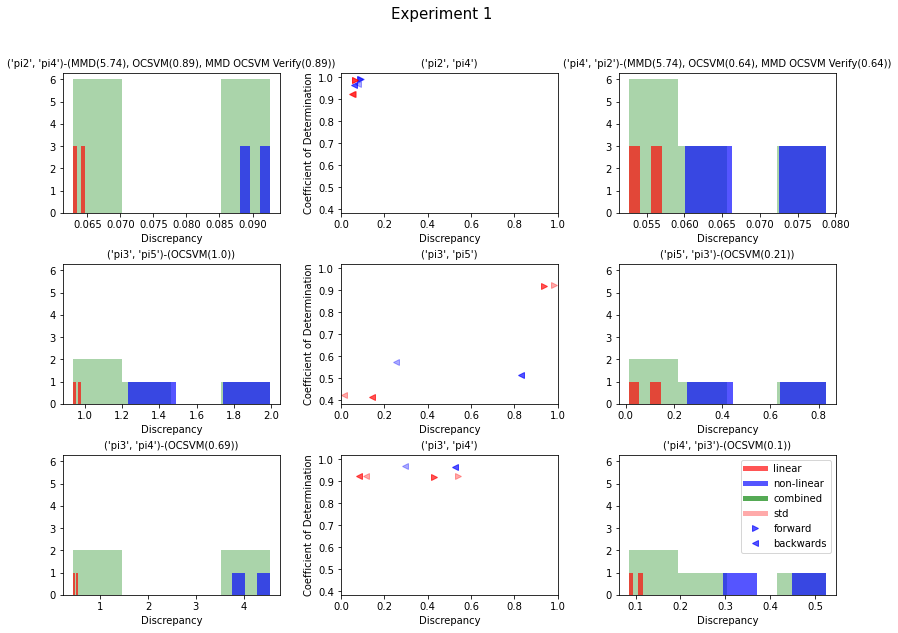

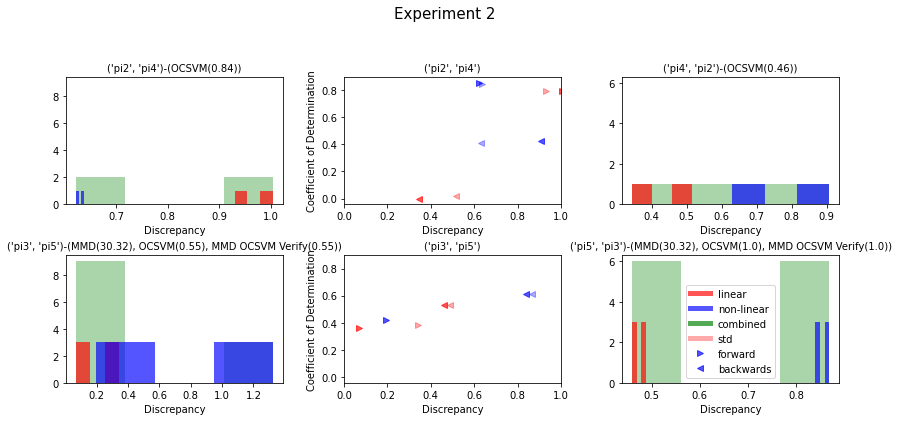

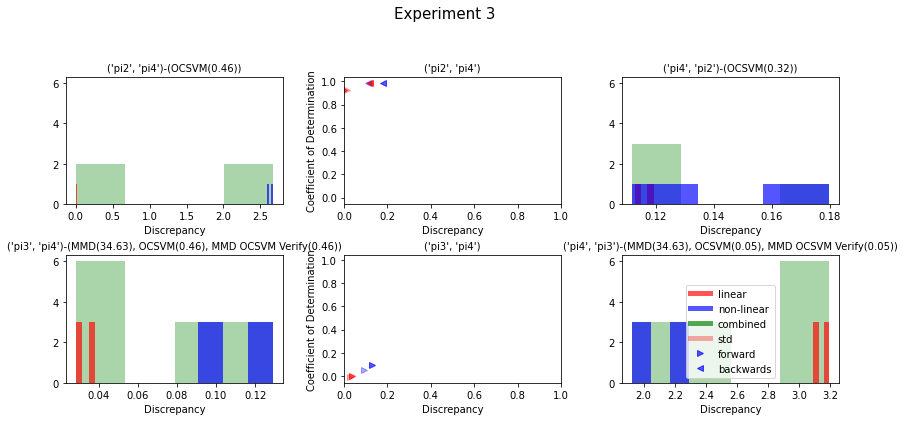

In [26]:
data = pd.read_csv(f"results/sample_{1}.csv") 
stats = plot_r2_discrpenacy(data, omit_bad_pairs=True, use_samples)

In [27]:
stats[1]

,count,mean,std,min,25%,50%,75%,max
"('pi2', 'pi4')",12.0,0.077035,0.014048,0.062802,0.064143,0.076344,0.089235,0.092648
"('pi4', 'pi2')",12.0,0.062164,0.010385,0.052651,0.055990,0.058625,0.064798,0.078754
"('pi3', 'pi5')",4.0,1.285957,0.490255,0.935173,0.969444,1.107039,1.423552,1.994575
"('pi5', 'pi3')",4.0,0.310784,0.360441,0.012560,0.112302,0.199932,0.398414,0.830710
"('pi3', 'pi4')",4.0,2.317379,2.141851,0.429478,0.511743,2.146005,3.951641,4.548028
"('pi4', 'pi3')",4.0,0.254996,0.202201,0.084879,0.108064,0.205171,0.352102,0.524763


In [28]:
stats[2]

,count,mean,std,min,25%,50%,75%,max
"('pi2', 'pi4')",4.0,0.798271,0.197310,0.621755,0.633462,0.783410,0.948219,1.004511
"('pi4', 'pi2')",4.0,0.598910,0.237119,0.343048,0.471908,0.572602,0.699604,0.907388
"('pi3', 'pi5')",12.0,0.482208,0.519163,0.067615,0.161646,0.267313,0.587875,1.326591
"('pi5', 'pi3')",12.0,0.663772,0.198913,0.459240,0.481217,0.663784,0.846340,0.868280


In [29]:
stats[3]

,count,mean,std,min,25%,50%,75%,max
"('pi2', 'pi4')",4.0,1.320145,1.517058,0.001347,0.009317,1.302283,2.613110,2.674669
"('pi4', 'pi2')",4.0,0.130829,0.032847,0.111708,0.112375,0.115880,0.134334,0.179846
"('pi3', 'pi4')",12.0,0.071558,0.042700,0.028353,0.035595,0.064304,0.100266,0.129269
"('pi4', 'pi3')",12.0,2.625487,0.559880,1.923917,2.197712,2.691429,3.119204,3.195171


In [30]:
samples = {}
for sample_id in range(1,5):
    sample = pd.read_csv(f"results/per method/sample_{sample_id}.csv")
    experiment_data = {}
    for experiment in range(1,4):
        experiment_similar_pairs  = ""
        for method in methods:
            df = data.loc[(sample.experiment==experiment)&(data.method==method)]
            unique_pairs_df = pd.DataFrame.from_records(np.unique(df[["model_node", "test_node"]].to_records(index=False)))
            similar_pairs = sort_similar_pairs(unique_pairs_df)
            experiment_similar_pairs += str(similar_pairs[::2])
        experiment_data[experiment] = experiment_similar_pairs
    samples[f"sample_{sample_id}"] = experiment_data

In [31]:
samples["sample_1"] == samples["sample_2"] == samples["sample_3"] == samples["sample_4"]       

True

In [32]:
data = pd.read_csv(f"results/sample_{1}.csv") 

In [43]:
data.loc[(data.method == "OCSVM")&(data.model_node=="pi3")]

,model_node,model,score,test_node,discrepancy,method,std,experiment,threshold,sample pair calculation
15,pi3,"SVR(C=0.1, epsilon=0.2)",0.101657,pi4,0.131187,OCSVM,False,3,0.71,True
16,pi3,"SVR(C=0.1, epsilon=0.2)",0.101657,pi5,3.757239,OCSVM,False,3,1.00,True
21,pi3,SVR(kernel='linear'),0.023244,pi4,0.197011,OCSVM,False,3,0.71,True
22,pi3,SVR(kernel='linear'),0.023244,pi5,3.528464,OCSVM,False,3,1.00,True
27,pi3,LinearRegression(),0.031748,pi4,0.396308,OCSVM,False,3,0.71,True
28,pi3,LinearRegression(),0.031748,pi5,3.455294,OCSVM,False,3,1.00,True
33,pi3,SVR(C=0.1),0.045559,pi4,0.077916,OCSVM,True,3,0.71,True
34,pi3,SVR(C=0.1),0.045559,pi5,3.734328,OCSVM,True,3,1.00,True
39,pi3,"SVR(C=0.01, epsilon=0, kernel='linear')",0.000203,pi4,0.024307,OCSVM,True,3,0.71,True
40,pi3,"SVR(C=0.01, epsilon=0, kernel='linear')",0.000203,pi5,3.625119,OCSVM,True,3,1.00,True


In [13]:
data

,model_node,model,score,test_node,discrepancy,method,std,experiment,threshold
0,pi2,"SVR(C=100, epsilon=1)",0.990594,pi4,0.088098,MMD,False,1,5.74
1,pi4,"SVR(C=100, epsilon=0.5)",0.965719,pi2,0.060146,MMD,False,1,5.74
2,pi2,"SVR(C=0.01, epsilon=0.5, kernel='linear')",0.987196,pi4,0.062802,MMD,False,1,5.74
3,pi4,"SVR(C=0.01, epsilon=1, kernel='linear')",0.923151,pi2,0.052651,MMD,False,1,5.74
4,pi2,LinearRegression(normalize=True),0.987297,pi4,0.063713,MMD,False,1,5.74
...,...,...,...,...,...,...,...,...,...
187,pi3,SVR(),0.054262,pi4,0.090598,MMD OCSVM Verify,True,3,0.46
188,pi4,SVR(kernel='linear'),0.986590,pi3,3.195171,MMD OCSVM Verify,True,3,0.05
189,pi3,"SVR(C=100, epsilon=0.01, kernel='linear')",-0.006941,pi4,0.028353,MMD OCSVM Verify,True,3,0.46
190,pi4,LinearRegression(),0.986599,pi3,3.243628,MMD OCSVM Verify,True,3,0.05
